In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import sys
import matplotlib as mpl

#insert path
sys.path.insert(0, '../methods/')

sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

sys.modules.pop('ARWQE', None)
from ARWQE import *

sys.modules.pop('plots', None)
from plots import *

AttributeError: module 'sys' has no attribute 'insert'

In [2]:
alpha =0.1; delta = 0.1; gamma=1
num_periods = 1000
num_trials = 2

#NOTE: uncomment to change shift patterns
#beta_1 = 2 * np.sin(np.linspace(0, 5*np.pi, num_periods)) + 5
beta_1 = np.ones(num_periods)
#beta_1 = generate_true_means(num_periods-1, 2)
beta_2 = np.ones(num_periods)
#plt.plot(beta_1)
#plt.show()
beta = np.column_stack((beta_1, beta_2))
variance_y = 1; meanX = 1

np.random.seed(6)

#B_arr is for val set
B_arr = np.random.randint(low=1, high=2, size=num_periods)
B_arr_starts = np.arange(num_periods)
B_arr_ends = np.cumsum(B_arr) - 1

#for training set
B_arr_tr = 10 * B_arr

#NOTE: all the above can be tuned

fixed_windows = [1, 4, 16, 64, 256, 1024]

cdf_dict = create_empty_dict(fixed_windows, num_trials)
interval_dict = create_empty_dict(fixed_windows, num_trials)

seeds = np.arange(num_trials) + 2024

for (trial, seed) in tqdm(enumerate(seeds)):
    
    np.random.seed(seed)

    X_tr, y_tr = generate_linreg_data(meanX, B_arr_tr, beta, variance_y)
    X_val, y_val = generate_linreg_data(meanX, B_arr, beta, variance_y)

    k_hat_all = []
    for t in range(num_periods):
        
        idx = B_arr_ends[t]+1

        reg, S_t = fit_and_get_scores(X_tr[:idx], y_tr[:idx], X_val[:idx], y_val[:idx])

        B_arr_t = B_arr[:t+1]

        khat, qt_khat, qtk_all = ARWQE(S_t, B_arr_t, alpha, delta, gamma)
        k_hat_all.append(khat)
        beta_t = beta[t]

        #compute coverage
        dimX = X_tr.shape[1]

        #approximate by generating ~1000 X, Y from this period 
        # and calculate coverage of prediction set
        X_test = generate_multinomial_X(meanX, dimX, 1000)
        y_hat = reg.predict(X_test)

        mu_test = X_test @ beta[t].T
        Y_test = mu_test + np.random.normal(0, variance_y, 1000)  

        coverage_ARW = monte_carlo_coverage(y_hat, qt_khat, Y_test)
        #cdf_dict['ARW'][trial].append(np.abs(coverage_ARW - 1+alpha))
        cdf_dict['ARW'][trial].append(coverage_ARW)
        interval_dict['ARW'][trial].append(qt_khat)

        #baseline: take quantile of fixed k
        #qtk_fixed = compute_qtk(S_t, np.array(fixed_windows), B_arr_t, alpha)
        for ik, k in enumerate(fixed_windows):
            log2k = int(np.log2(k))
            qtk = qtk_all[min(log2k, len(qtk_all)-1)]
            coverage_k = monte_carlo_coverage(y_hat, qtk, Y_test)
            cdf_dict[f'Val_{k}'][trial].append(coverage_k)
            interval_dict[f'Val_{k}'][trial].append(qtk)

    #plot k_hat_all
    #plt.plot(k_hat_all)

2it [00:04,  2.17s/it]


mae [0.01163944 0.40739944 0.13237556 0.0563     0.02618722 0.01446556
 0.01154111]
se_ae [0.00022981 0.00022981 0.00232245 0.00070789 0.00113726 0.00031741
 0.00028441]
mse [2.01529444e-04 2.41193385e-01 3.52302478e-02 5.54240556e-03
 1.18377167e-03 3.04114444e-04 1.98524444e-04]
se_mse [1.01285190e-05 3.83397618e-04 9.18777625e-04 6.41361564e-05
 1.72392240e-04 1.10842916e-05 1.18393245e-05]
mean_interval [3.38995309 1.62817938 3.01425205 3.44091912 3.37701338 3.38238246
 3.38893179]
se_interval [0.01034647 0.00182866 0.00968543 0.0022797  0.01839476 0.00714296
 0.00981273]


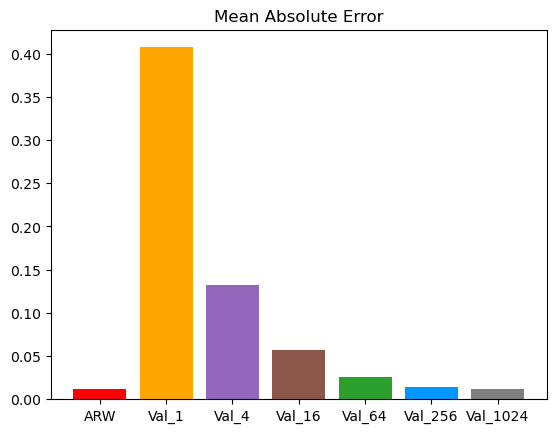

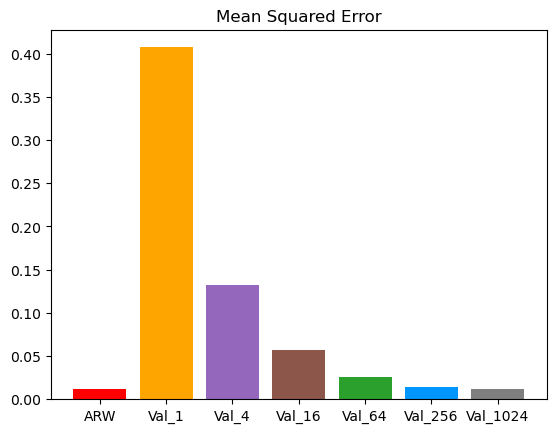

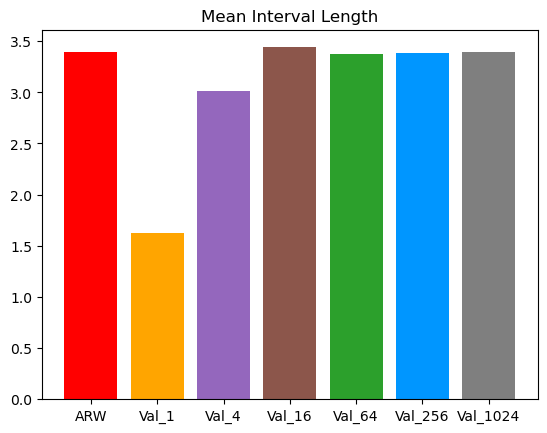

In [3]:
#process results in cdf_dict
methods = ['ARW'] + [f'Val_{k}' for k in fixed_windows]
cdf_array, mae_array, mae, se_ae, mse_array, mse, se_mse = summarize_cdf_dict(methods, num_trials, num_periods, cdf_dict, alpha)
print('mae', mae)
print('se_ae', se_ae)
print('mse', mse)
print('se_mse', se_mse)

interval_array, mean_interval, se_interval = summarize_interval_dict(methods, num_trials, num_periods, interval_dict)
print('mean_interval', mean_interval)
print('se_interval', se_interval)

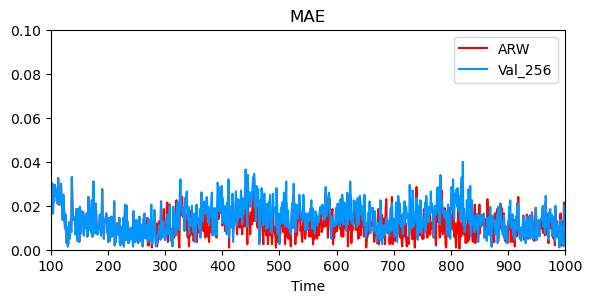

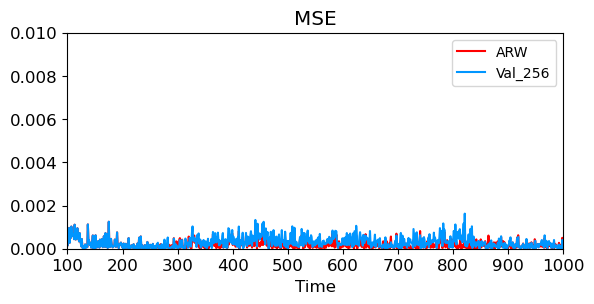

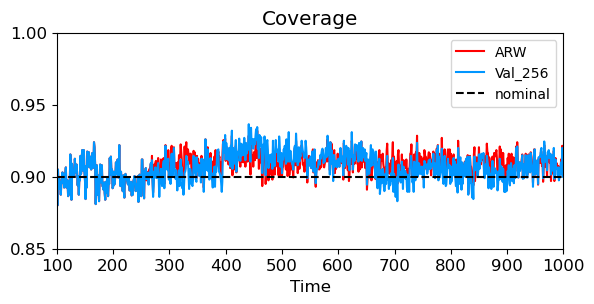

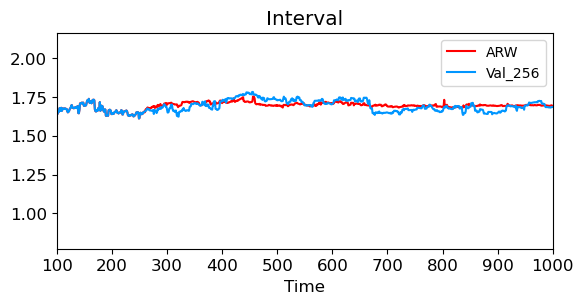

In [4]:
#plot cdf over time periods for ARW, V1, V256
colors = ['r', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF', 'tab:gray']
methods = ['ARW', 'Val_1', 'Val_4', 'Val_16', 'Val_64', 'Val_256', 'Val_1024']

#NOTE: uncomment to change the index of the methods to plot
methods_to_plot = [0, 5]

mae_over_trials = np.mean(mae_array[:, :, :], axis=1)
mse_over_trials = np.mean(mse_array[:, :, :], axis=1)
cdf_over_trials = np.mean(cdf_array[:, :, :], axis=1)
interval_over_trials = np.mean(interval_array[:, :, :], axis=1)

plot_over_time(colors, methods, 100, 1000, mae_over_trials, methods_to_plot, title='MAE')
#NOTE: adjust ylim for zooming in 
plt.ylim(0, 0.1)

plot_over_time(colors, methods, 100, 1000, mse_over_trials, methods_to_plot, title='MSE')
plt.ylim(0, 0.01)

plot_over_time(colors, methods, 100, 1000, cdf_over_trials, methods_to_plot, title='Coverage', alpha=0.1)
plt.ylim(0.85, 1.0)
plot_over_time(colors, methods, 100, 1000, interval_over_trials, methods_to_plot, title='Interval')

#plt.savefig(f'{DATAPATH}/{figname}_time_var{variance}.png', dpi=300, bbox_inches='tight')